### Question 2

In [47]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold

def Create_GMM():
    gmm = {} # dict for true GMM parameters
    gmm['meanVectors'] = np.array([
        [0.0, 0.0],
        [1.0, 1.0], # close with [0,0] for overlap
        [5.0, 0.0],
        [0.0, 5.0],
    ], dtype=float)

    gmm['covMatrices'] = np.array([
        [[0.9,  0.2], [ 0.2, 0.6]],
        [[0.8,  0.1], [ 0.1, 0.7]], # close with first cov for overlap
        [[1.2,  0.0], [ 0.0, 0.8]],
        [[0.7, -0.1], [-0.1, 0.9]],
    ], dtype=float)
    
    gmm['priors'] = np.array([0.35, 0.25, 0.25, 0.15], dtype=float) # random probality selection
    gmm['priors'] /= gmm['priors'].sum() # normalize
    return gmm

In [ ]:
def Sample_GMM(N, GMM, rng):
    priors = GMM['priors']
    means = GMM['meanVectors']
    covs  = GMM['covMatrices']

    C = len(priors) # number of components
    N = int(N)

    # Choose component labels according to priors before sampling
    u = rng.random(N)
    thresholds = np.cumsum(priors) # cumulative sum for each component
    labels = np.searchsorted(thresholds, u) # label 0, 1, 2, 3

    # For each component, sample
    X = np.zeros((N, 2))
    for c in range(C):
        idx = np.where(labels == c)[0]
        Nc = len(idx)
        if Nc > 0:
            X[idx, :] = rng.multivariate_normal(means[c], covs[c], size=Nc)

    return X, labels

rng = default_rng(123)
gmm = Create_GMM()
X10, label1 = Sample_GMM(10, gmm, rng)
X100, _ = Sample_GMM(100, gmm, rng)
X1000, _ = Sample_GMM(1000, gmm, rng)

print("Labels:", label1)
print("Shapes:", X10.shape, X100.shape, X1000.shape)
print(f"X10[0]: {X10[0:4]} \nX100[0]: {X100[0:4]} \nX1000[0]: {X1000[0:4]}")

Labels: [2 0 0 0 0 2 3 0 2 3]
Shapes: (10, 2) (100, 2) (1000, 2)
X10[0]: [[ 2.58183657  0.74051545]
 [ 0.39563247 -1.00853767]
 [-0.85408859 -0.95758727]
 [-0.93777669 -0.36111703]] 
X100[0]: [[ 0.90607843  5.44362288]
 [ 0.90527669  4.0196764 ]
 [-0.14860715  0.12700143]
 [ 0.93304292  5.62345189]] 
X1000[0]: [[ 5.10843139  0.60806194]
 [-2.66937407  0.37199503]
 [ 2.28741594  0.76608327]
 [ 5.48208789  0.81454084]]


In [ ]:
import plotly.graph_objects as go

X_vis, y_vis = Sample_GMM(1000, gmm, default_rng(456))
means = gmm['meanVectors']
num_class = means.shape[0] # 4 classes

fig = go.Figure()

# Plot each component
for c in range(num_class):
    pts = X_vis[y_vis == c]
    fig.add_trace(go.Scatter(
        x=pts[:, 0], y=pts[:, 1],
        mode='markers',
        marker=dict(size=4, opacity=0.35),
        name=f"Component {c}"
    ))
    # Plot the true mean as a diamond
    fig.add_trace(go.Scatter(
        x=[means[c, 0]], y=[means[c, 1]],
        mode='markers',
        marker=dict(size=10, symbol='diamond', line=dict(width=1, color='black')),
        name=f"Mean {c}"
    ))

fig.update_layout(
    title="GMM data distribution",
    xaxis_title="x1",
    yaxis_title="x2",
    legend=dict(x=1.02, y=1.0),
    margin=dict(l=0, r=0, t=40, b=0),
)

fig.show()


num_class: 4


### k-fold cross-validation and EM process

In [ ]:
def select_k_order(X, K_list=range(1, 11), n_splits=10, random_state=0):
    n = len(X) # number of samples
    n_splits = min(n_splits, max(2, n)) # at least 2 folds

    # Compute the smallest training fold size (in worst case)
    min_train_size = n - int(np.ceil(n / n_splits))
    K_iter = [k for k in K_list if k <= max(1, min_train_size)] # at least 1

    best_k, best_score = None, -np.inf
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for K in K_iter:
        fold_scores = [] # scores for each fold
        
        for train_idx, val_idx in kf.split(X):
            Xtrain, XVal = X[train_idx], X[val_idx] # get train and val splits

            # Create GMM
            GMM = GaussianMixture(
                n_components=K, covariance_type='full',
                reg_covar=1e-6,
                n_init=10, # run EM 10 times
                init_params='kmeans',
                max_iter=500 # max EM iterations
            )

            GMM.fit(Xtrain) # EM on train data
            ll_total = GMM.score(XVal) * len(XVal) # log-likelihood on val
            fold_scores.append(ll_total) # append to list

        avg_total_ll = float(np.mean(fold_scores)) # get average log-likelihood
        if avg_total_ll > best_score:
            best_score, best_k = avg_total_ll, K

    return best_k, best_score


In [59]:
def run_test(Ns=(10, 100, 1000), repeats=100):
    rng = default_rng(123)
    GMM = Create_GMM()
    
    selection_counts = {N: Counter() for N in Ns} # counter for each N

    for N in Ns:
        for r in range(repeats):
            X, _ = Sample_GMM(N, GMM, rng)
            best_k, _ = select_k_order(X, K_list=range(1, 11), n_splits=10, random_state=r)
            selection_counts[N][best_k] += 1
    return selection_counts

selection_counts = run_test(Ns=(10, 100, 1000), repeats=100)

In [60]:
# Create output table
for N, counts in selection_counts.items():
    total = sum(counts.values())
    print(f"\nDataset size N={N} (100 repeats)")
    for k in range(1, 11):
        freq = counts[k]
        rate = freq / total if total else 0.0
        print(f"K={k:2d}: selected {freq} times ({rate:5.1%})")


Dataset size N=10 (100 repeats)
K= 1: selected 94 times (94.0%)
K= 2: selected 6 times ( 6.0%)
K= 3: selected 0 times ( 0.0%)
K= 4: selected 0 times ( 0.0%)
K= 5: selected 0 times ( 0.0%)
K= 6: selected 0 times ( 0.0%)
K= 7: selected 0 times ( 0.0%)
K= 8: selected 0 times ( 0.0%)
K= 9: selected 0 times ( 0.0%)
K=10: selected 0 times ( 0.0%)

Dataset size N=100 (100 repeats)
K= 1: selected 0 times ( 0.0%)
K= 2: selected 1 times ( 1.0%)
K= 3: selected 88 times (88.0%)
K= 4: selected 10 times (10.0%)
K= 5: selected 1 times ( 1.0%)
K= 6: selected 0 times ( 0.0%)
K= 7: selected 0 times ( 0.0%)
K= 8: selected 0 times ( 0.0%)
K= 9: selected 0 times ( 0.0%)
K=10: selected 0 times ( 0.0%)

Dataset size N=1000 (100 repeats)
K= 1: selected 0 times ( 0.0%)
K= 2: selected 0 times ( 0.0%)
K= 3: selected 77 times (77.0%)
K= 4: selected 18 times (18.0%)
K= 5: selected 5 times ( 5.0%)
K= 6: selected 0 times ( 0.0%)
K= 7: selected 0 times ( 0.0%)
K= 8: selected 0 times ( 0.0%)
K= 9: selected 0 times ( 

dict_items([(10, Counter({1: 94, 2: 6})), (100, Counter({3: 88, 4: 10, 2: 1, 5: 1})), (1000, Counter({3: 77, 4: 18, 5: 5}))])


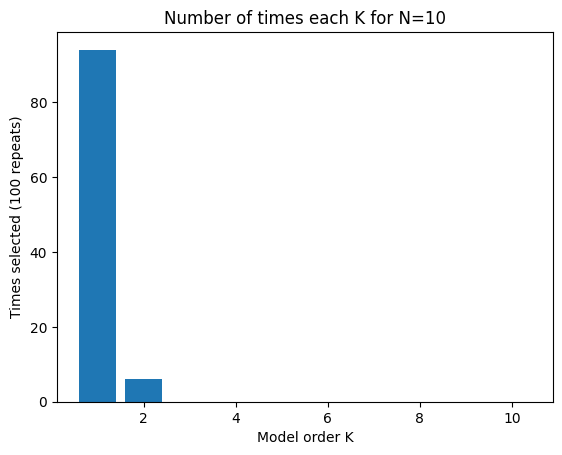

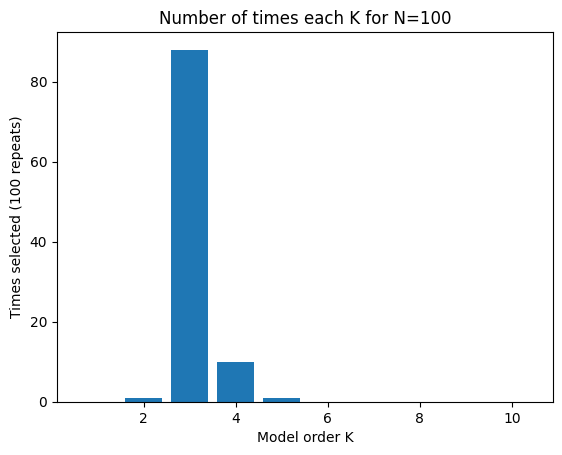

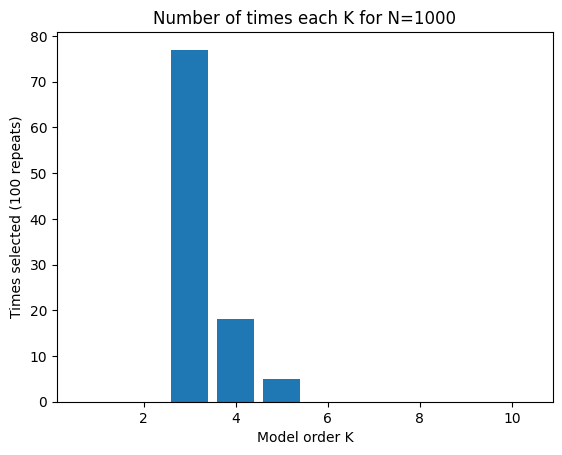

In [61]:
print(selection_counts.items())

# plot each N as a histogram
for N, counts in selection_counts.items():
    ks = range(1, 11)
    vals = [counts[k] for k in ks]
    plt.figure()
    plt.bar(ks, vals)
    plt.xlabel("Model order K")
    plt.ylabel("Times selected (100 repeats)")
    plt.title(f"Number of times each K for N={N}")
    plt.show()
